In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json, pickle
import argparse

import numpy as np
import pandas as pd
import torch
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter
from tbparse import SummaryReader


In [3]:
%load_ext autoreload
%autoreload 2

from src.vae_models import CVAE
import src.datasets as datasets
import src.utils as utils
import src.preprocess_lib as preprocess_lib
import src.conditioning_lib as conditioning_lib
from src.user_encoding_lib import UserEncoder


In [4]:
config_dir = 'runs/sweep_runs'
config_file = 'config.json'


In [14]:
df_experiment = pd.DataFrame()
for i, folder in enumerate(os.listdir(os.path.join(config_dir))):
    # Load config file
    with open(os.path.join(config_dir, folder, config_file), 'r') as f: config = json.load(f)
    config_flt = utils.flatten_dict(config)
    for tag in os.listdir(os.path.join(config_dir, folder, 'tensorboard')):
        tag_folder = os.path.join(config_dir, folder, 'tensorboard', tag)
        loss = SummaryReader(tag_folder).scalars["value"].values[-1]
        config_flt[tag] = loss
    df_experiment = pd.concat([df_experiment, pd.DataFrame(config_flt, index=[i])], axis=0)

In [15]:
##change column names 
df_experiment.rename(columns={'Loss_ELBO_val': 'ELBO (Validation)', 
                              'Loss_RLL_val': 'Reconstruction Log-likelihood (Validation)', 
                              'Loss_KL_val': 'KL Divergence (Validation)',
                              'data_ampute_params_b': 'Amputation Rate (b)',
                              'data_condition_tag_list': 'Conditions',
                              'model_distribution_dict_likelihood_dist_type': 'Likelihood Distribution',
                              'data_user_embedding_kwargs_model_kwargs_num_topics': 'Number of LDA Topics',
                              'data_user_embedding_kwargs_model_kwargs_num_clusters': 'Number of LDA Clusters',
                              'model_distribution_dict_likelihood_vocab_size': 'Pattern Dictionary Size',
                              }, inplace=True)

In [16]:
relplot_kwargs = {  
                    'data': df_experiment,
                    'x': 'Number of LDA Topics',
                    'col': 'Amputation Rate (b)',
                    'style': 'Conditions',
                    'hue': 'Likelihood Distribution',
                    'size': 'Number of LDA Clusters',
                    'alpha': 0.7}

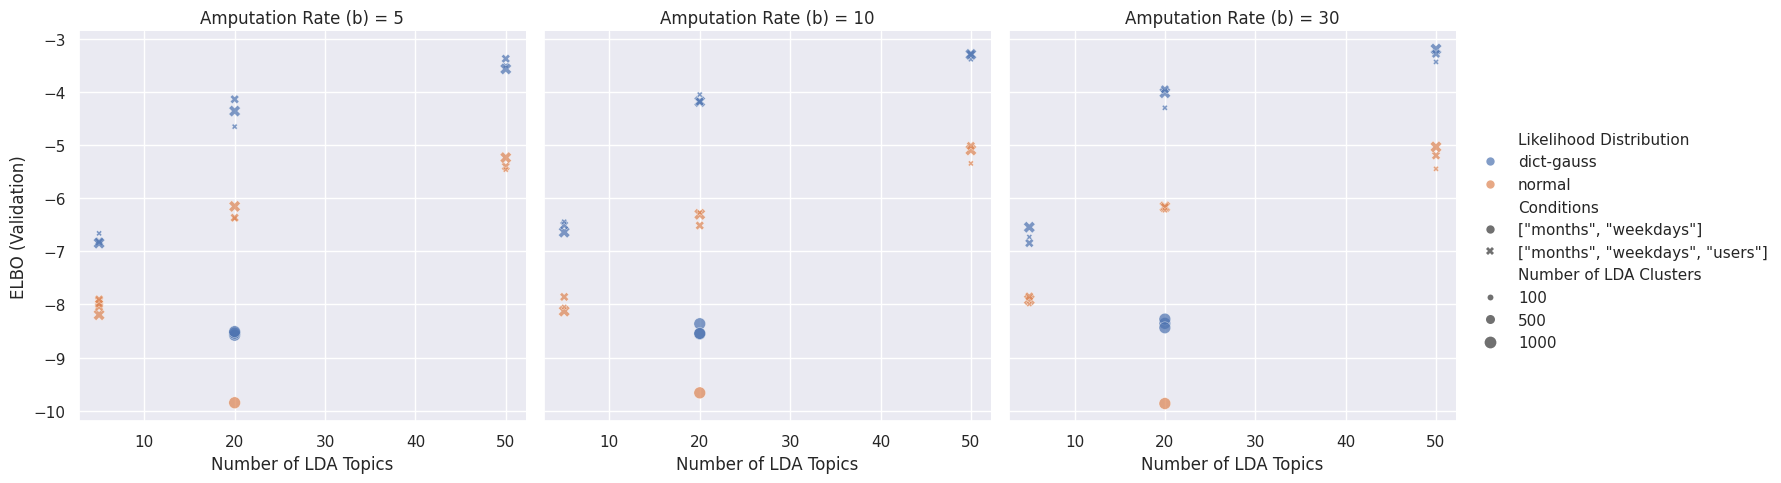

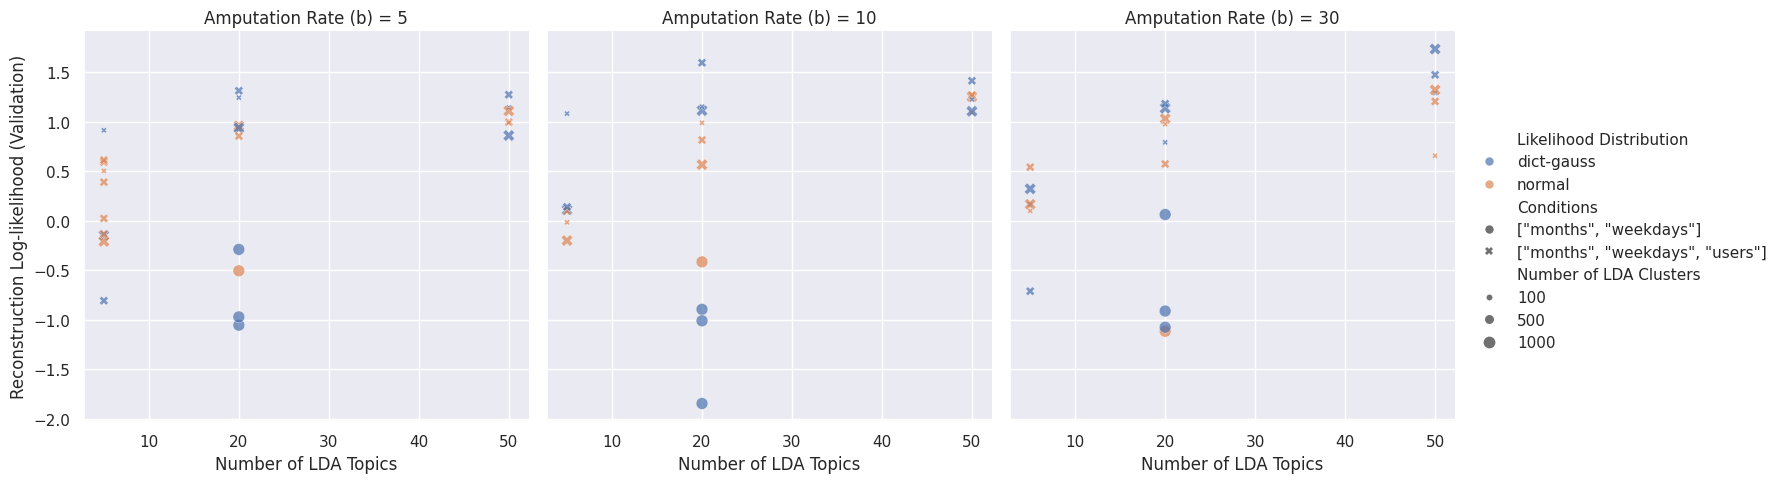

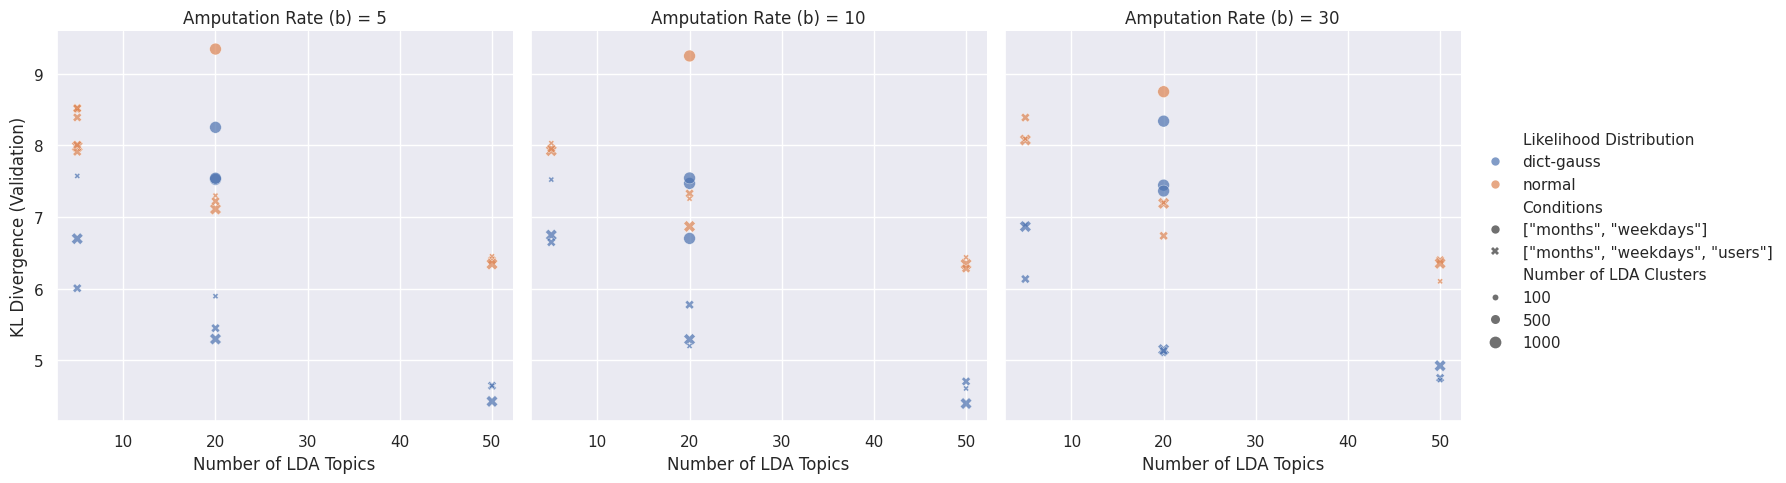

In [17]:
h = sns.relplot(y='ELBO (Validation)', **relplot_kwargs)
# h.set_xlabels(size=10)
plt.show()
h = sns.relplot(y='Reconstruction Log-likelihood (Validation)', **relplot_kwargs)
plt.show()
h = sns.relplot(y='KL Divergence (Validation)', **relplot_kwargs)
plt.show()

